Making a gif with the 1144 data.

In [8]:
#first get the python modules we need
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.convolution import convolve, Box1DKernel
from astropy.table import Table
import astropy.units as u
from matplotlib.animation import FuncAnimation
from astropy.modeling import models, fitting


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [9]:
path = '/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/' #note the / on the end
vispath = path + 'VIS_notell/'

In [10]:
phase_table = Table.read('taurus/phase_period_4.216.csv')

In [11]:
mjds = []
fits_files = glob.glob(vispath+'*TAC.fits')
for f in fits_files:
    mjds.append(fits.getheader(f)['MJD-OBS'])
t_fold = (np.array(mjds)*24)/4.23
t_fold  %= 1
args = np.argsort(t_fold)
fits_files = np.array(fits_files)[args]
csv_files = [f[:-4]+'csv' for f in fits_files]
#print(csv_files)


In [23]:
fitter = fitting.LinearLSQFitter()

def make_plot_spec(w, f, mask1, mask2): #cuts spectrum down to the bit to plot
    #mask = (w > 8450) & (w < 8480) | (w > 8520) & (w <8540) | (w > 8560) & (w< 8660) | (w > 8680) & (w < 8700) #mask out emmission lines
    w1, f1 = w[mask1], f[mask1]
    n_init = models.Polynomial1D(3)
    n_fit = fitter(n_init, w1, f1)
    #mask = (w > 8450) & (w < 8700)
    w1, f1 = w[mask2], f[mask2]
    nf = f1/n_fit(w1)
    nf = convolve(nf,Box1DKernel(10))
    return w1,nf

 [astropy.modeling.fitting]


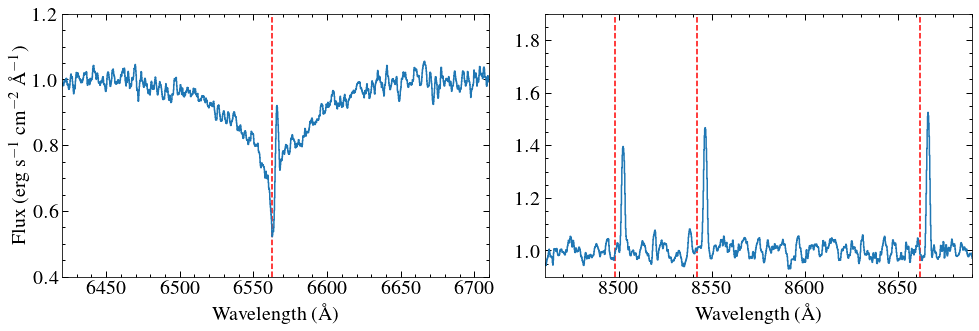

In [24]:


from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_tight_layout(True)

#ax[0].plot(t, f_lc)
#ax[0].set_xlabel('Time (s)')
#ax[0].set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$)')
ax[0].set_ylim(0.4, 1.2)
ax[0].set_xlim(6420, 6710)

#line, = ax[0].plot([0,0], [-0.1e-12,1.3e-12], 'C1--', linewidth=2)
ax[1].set_ylim(0.9, 1.9)
ax[1].set_xlim(8460, 8690)
#ax[1].set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax[1].set_xlabel('Wavelength (\AA)')
ax[0].set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax[0].set_xlabel('Wavelength (\AA)')
ax[0].axvline(6562.77, ls='--', c='r')
[ax[1].axvline(line, ls='--', c='r') for line in [8498.02,8542.09,8662.14]]


#ext = hdul[1::][0]
#dt = ext.data[0]
#w, f = dt['WAVELENGTH'], dt['FLUX']
w, f,e  = np.loadtxt(csv_files[0], unpack=True, delimiter=',')
mask1 = (w>6400) &  (w <6450 ) | (w>6650) &  (w <6800 )
mask2 = (w>6400) &  (w <6800 )
mask3 = (w > 8450) & (w < 8480) | (w > 8520) & (w <8540) | (w > 8560) & (w< 8660) | (w > 8680) & (w < 8700) #mask out emmission lines
mask4 = (w > 8450) & (w < 8700)
w1, nf1 = make_plot_spec(w,f, mask1, mask2)
w2, nf2 = make_plot_spec(w,f, mask3, mask4)
line1, = ax[0].step(w1,nf1, where='mid')
line2, = ax[1].step(w2,nf2, where='mid')

def update(i):
    #time = t[i]
    #line.set_xdata([t[i], t[i]])
    #ext = hdul[1::][i]
    #dt = ext.data[0]
    w, f,e  = np.loadtxt(csv_files[i], unpack=True, delimiter =',')
    mask1 = (w>6400) &  (w <6450 ) | (w>6650) &  (w <6800 )
    mask2 = (w>6400) &  (w <6800 )
    mask3 = (w > 8450) & (w < 8480) | (w > 8520) & (w <8540) | (w > 8560) & (w< 8660) | (w > 8680) & (w < 8700) #mask out emmission lines
    mask4 = (w > 8450) & (w < 8700)
    w1, nf1 = make_plot_spec(w,f, mask1, mask2)
    w2, nf2 = make_plot_spec(w,f, mask3, mask4)
    line1.set_xdata(w1)
    line1.set_ydata(nf1)
    line2.set_xdata(w2)
    line2.set_ydata(nf2)
    return ax, line1, line2

anim = FuncAnimation(fig, update, frames=np.arange(len(csv_files)), interval=250)
anim.save('test.gif', dpi=80, writer='imagemagick')
plt.show()

